In [1]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
from matplotlib import style
import time

In [2]:
style.use('ggplot')

In [3]:
FORECAST_COL = 'Adj. Close'
FORECAST_LABEL = 'Forecast'
LABEL = 'label'
STOCK_NAME = "WIKI/GOOGL"

In [4]:
df = quandl.get(STOCK_NAME)
print(df.tail())
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

              Open      High       Low   Close     Volume  Ex-Dividend  \
Date                                                                     
2017-06-29  951.35  951.6600  929.6000  937.82  3182331.0          0.0   
2017-06-30  943.99  944.9995  929.6100  929.68  2185444.0          0.0   
2017-07-03  933.22  934.2400  915.3100  919.46  1694587.0          0.0   
2017-07-05  924.20  936.2900  918.6305  932.26  2054927.0          0.0   
2017-07-06  925.00  936.1400  919.8500  927.69  1941822.0          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj. Low  Adj. Close  \
Date                                                                  
2017-06-29          1.0     951.35   951.6600  929.6000      937.82   
2017-06-30          1.0     943.99   944.9995  929.6100      929.68   
2017-07-03          1.0     933.22   934.2400  915.3100      919.46   
2017-07-05          1.0     924.20   936.2900  918.6305      932.26   
2017-07-06          1.0     925.00   936.1400  919.8500

In [5]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
print(FORECAST_LABEL, forecast_out)
df[LABEL] = df[FORECAST_COL].shift(-forecast_out)

('Forecast', 33)


In [6]:
X = np.array(df.drop([LABEL], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [7]:
df.dropna(inplace=True)
y = np.array(df[LABEL])

In [8]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

In [9]:
print ("Accuracy: ", accuracy)

('Accuracy: ', 0.96936472366819493)


In [10]:
forecast_set = clf.predict(X_lately)
df[FORECAST_LABEL] = np.nan

In [11]:
last_date = df.iloc[-1].name
last_unix = time.mktime(last_date.timetuple())
one_day = 86400
next_unix = last_unix + one_day

In [12]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [13]:
plt.figure(figsize=(20,10))
plot_days_size = int(math.ceil(0.03 * len(df)))
df = df[-plot_days_size:]

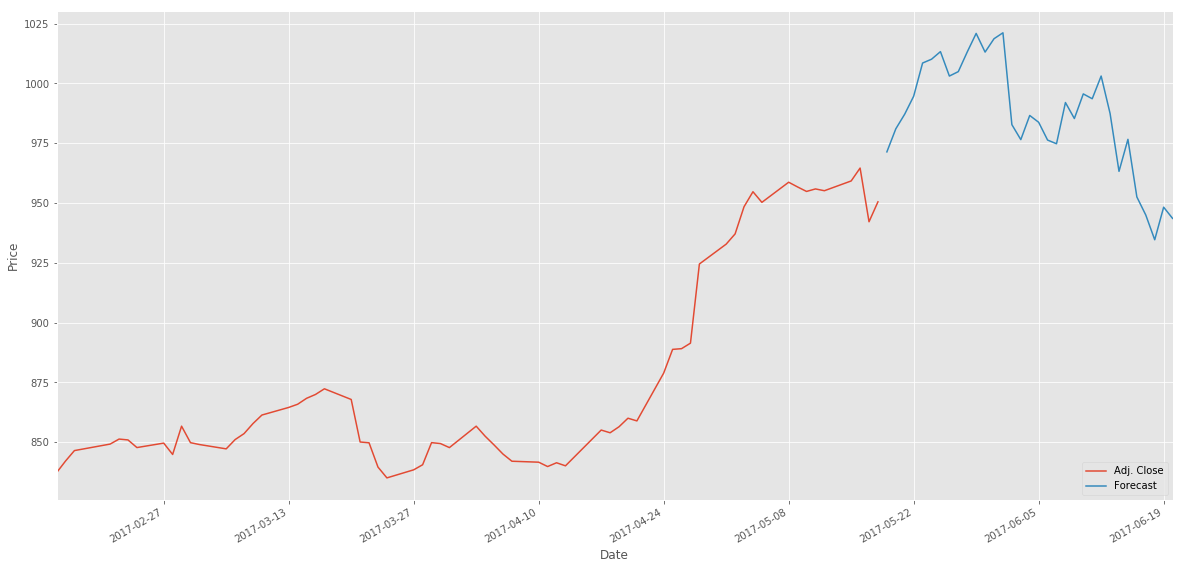

In [14]:
df[FORECAST_COL].plot()
df[FORECAST_LABEL].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()